In [ ]:
import pandas as p
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9836618035290822611
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3617181260341811776
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%store -r data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1600000 non-null  int64 
 1   ids         1600000 non-null  int64 
 2   date        1600000 non-null  object
 3   flag        1600000 non-null  object
 4   user        1600000 non-null  object
 5   text        1600000 non-null  object
 6   clean_text  1600000 non-null  object
dtypes: int64(2), object(5)
memory usage: 85.4+ MB


In [3]:
X = data['clean_text'].values
y = data['target'].values
y = np.array([i if i == 0 else 1 for i in y])
print(len(X))
print(len(y))

1600000
1600000


In [4]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.02, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5, random_state=0)
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)
np.unique(y_train, return_counts=True)

(1568000,) (1568000,) (16000,) (16000,) (16000,) (16000,)


(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64))

In [6]:
vectorizer = TfidfVectorizer(encoding='latin-1')
vec = vectorizer.fit_transform(X_train)
vocab_size = vec.shape[1]
embedding_dim = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding=padding_type)
print(len(train_sequences), train_padded.shape)

validation_sequences = tokenizer.texts_to_sequences(X_validation)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, padding=padding_type, maxlen=train_padded.shape[1])
print(len(validation_sequences), validation_padded.shape)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding=padding_type, maxlen=train_padded.shape[1])
print(len(test_sequences), test_padded.shape)

training_label_seq = np.array(y_train)
validation_label_seq = np.array(y_validation)
test_label_seq = np.array(y_test)
print(training_label_seq.shape, validation_label_seq.shape, test_label_seq.shape)
print(np.unique(training_label_seq, return_counts=True), np.unique(validation_label_seq, return_counts=True), np.unique(test_label_seq, return_counts=True))

1568000 (1568000, 40)
16000 (16000, 40)
16000 (16000, 40)
(1568000,) (16000,) (16000,)
(array([0, 1], dtype=int64), array([783999, 784001], dtype=int64)) (array([0, 1], dtype=int64), array([7933, 8067], dtype=int64)) (array([0, 1], dtype=int64), array([8068, 7932], dtype=int64))


In [10]:
def plot_graphs(history, string):
  plt.plot(range(1, len(history.history[string])+1), history.history[string])
  plt.plot(range(1, len(history.history['val_'+string])+1), history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
def save_model(model, name):
    model_json = model.to_json()
    with open(name + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(name + '.h5')
    print('Saved model to disk')

In [ ]:
def load_model(name):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(name + '.h5')
    print('Loaded model from disk')
    return loaded_model

In [28]:
# compile model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 200)           48437000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               135680    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 48,581,001
Trainable params: 48,581,001
Non-trainable params: 0
_________________________________________________________________


In [29]:
# train model
num_epochs = 2
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 26210s 17ms/sample - loss: 0.4012 - accuracy: 0.8168 - val_loss: 0.3848 - val_accuracy: 0.8266
Epoch 2/2
1568000/1568000 [==============================] - 21501s 14ms/sample - loss: 0.3403 - accuracy: 0.8510 - val_loss: 0.3923 - val_accuracy: 0.8232


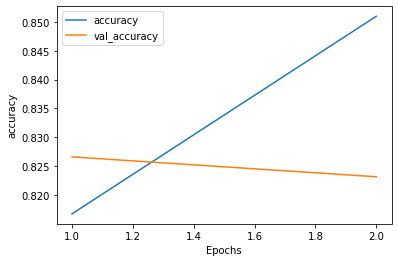

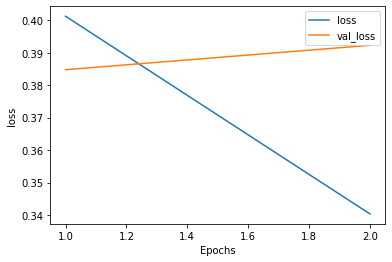

In [31]:
# plot model
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
# evaluate model
scores = model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

16000/16000 [==============================] - 3s 191us/sample - loss: 0.3934 - accuracy: 0.8262
accuracy: 82.62%


In [35]:
# save model
save_model(model, 'model')

Saved model to disk


In [37]:
# load model
loaded_model = load_model('model')

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 6s 362us/sample - loss: 0.3934 - accuracy: 0.8262
accuracy: 82.62%


In [38]:
# compile model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 200)           48437000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 48,806,921
Trainable params: 48,806,921
Non-trainable params: 0
_________________________________________________________________


In [39]:
# train model
num_epochs = 2
history2 = model2.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 25704s 16ms/sample - loss: 0.4037 - accuracy: 0.8160 - val_loss: 0.3847 - val_accuracy: 0.8285
Epoch 2/2
1568000/1568000 [==============================] - 26349s 17ms/sample - loss: 0.3440 - accuracy: 0.8497 - val_loss: 0.3903 - val_accuracy: 0.8266


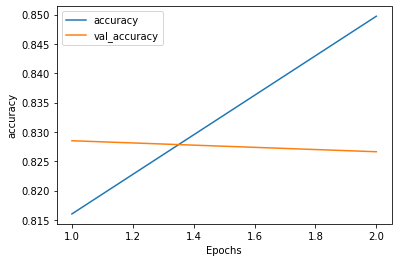

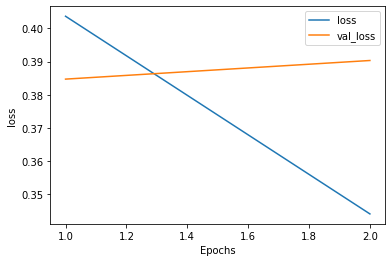

In [40]:
# plot model
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [41]:
# evaluate model
scores2 = model2.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

16000/16000 [==============================] - 2s 154us/sample - loss: 0.3897 - accuracy: 0.8253
accuracy: 82.53%


In [42]:
# save model
save_model(model2, 'model2')

Saved model to disk


In [43]:
# load model
loaded_model = load_model('model2')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 5s 318us/sample - loss: 0.3897 - accuracy: 0.8253
accuracy: 82.53%


In [7]:
# compile model
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           48437000  
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 128)           128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [8]:
# train model
num_epochs = 2
history3 = model3.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Train on 1568000 samples, validate on 16000 samples
Epoch 1/2
1568000/1568000 [==============================] - 23811s 15ms/sample - loss: 0.4070 - accuracy: 0.8141 - val_loss: 0.3935 - val_accuracy: 0.8205
Epoch 2/2
1568000/1568000 [==============================] - 25308s 16ms/sample - loss: 0.3518 - accuracy: 0.8453 - val_loss: 0.3969 - val_accuracy: 0.8206


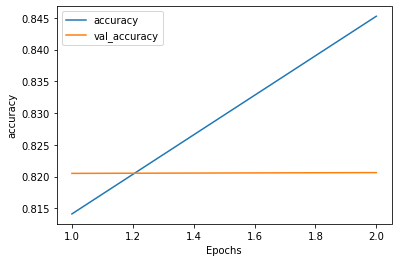

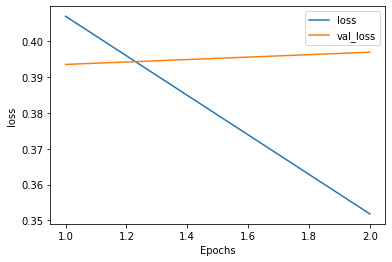

In [11]:
# plot model
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

In [12]:
# evaluate model
scores3 = model3.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (model3.metrics_names[1], scores3[1]*100))

16000/16000 [==============================] - 2s 155us/sample - loss: 0.3931 - accuracy: 0.8262
accuracy: 82.62%


In [13]:
# save model
save_model(model3, 'model3')

Saved model to disk


In [14]:
# load model
loaded_model = load_model('model3')
 
# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(test_padded, test_label_seq)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
16000/16000 [==============================] - 3s 177us/sample - loss: 0.3931 - accuracy: 0.8262
accuracy: 82.62%


In [15]:
import io

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

e = loaded_model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(242185, 200)
